# LPD Geometry and Image Mask

This notebook will show you how to assemble the modules of the LPD detector into a single image as well as apply, dismantle and assemble an image mask.

In [1]:
import multiprocessing as mp
import time

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from extra_data import RunDirectory
from pyfoamalgo.geometry import LPD_1MGeometry, stack_detector_modules
from pyfoamalgo import mask_image_data, nanmean

mp.cpu_count()

72

In [2]:
run = RunDirectory("/gpfs/exfel/exp/XMPL/201750/p700000/proc/r0007")

run.info()

# of trains:    507
Duration:       0:00:50.7
First train ID: 1487289920
Last train ID:  1487290426

13 detector modules (FXE_DET_LPD1M-1)
  e.g. module FXE_DET_LPD1M-1 0 : 256 x 256 pixels
  FXE_DET_LPD1M-1/DET/0CH0:xtdf
  30 frames per train, up to 15210 frames total

0 instrument sources (excluding detectors):

0 control sources: (1 entry per train)



In [3]:
_, train_data = run.train_from_index(0)

## Assembling

**Note:** ``stack_detector_modules`` returns an array-like wrapper around the existing arrays which avoid the data copy.

In [4]:
# Stack the detector modules into a single array.
modules_data = stack_detector_modules(train_data, 'FXE_DET_LPD1M-1/DET/*CH0:xtdf', 'image.data', modules=16)

modules_data.shape, modules_data.dtype

((30, 16, 256, 256), dtype('<f4'))

In [5]:
# Create the geometry with a geometry file and quadrant positions.
quad_pos = [(11.4, 299), (-11.5, 8), (254.5, -16), (278.5, 275)]  # mm
geom = LPD_1MGeometry.from_h5_file_and_quad_positions('lpd_mar_18_axesfixed.h5', quad_pos)

In [6]:
n_pulses = modules_data.shape[0]

# Allocate the assembled image array and reuse it as far as possible to speed up data processing.
assembled = geom.output_array_for_position_fast(extra_shape=(n_pulses,))
assembled.shape

(30, 1203, 1105)

In [7]:
t0 = time.perf_counter()

# Assemble modules data into a single image.
geom.position_all_modules(modules_data, out=assembled, ignore_tile_edge=True)

print(f"Assembling a train with {n_pulses} pulses takes: {1e3 * (time.perf_counter() - t0):.1f} ms")

Assembling a train with 30 pulses takes: 14.9 ms


**Note:** `nanmean` implemented in `pyfoamalgo` is much faster than `numpy.nanmean`.

In [8]:
t0 = time.perf_counter()

# Calculate the average (taking into account nan) of the assembled image.
assembled_mean = nanmean(assembled, axis=0)

print(f"Averaging a train with {n_pulses} pulses takes: {1e3 * (time.perf_counter() - t0):.1f} ms")

Averaging a train with 30 pulses takes: 7.0 ms


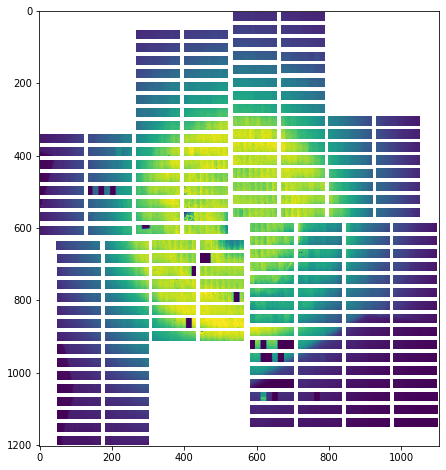

In [9]:
_, ax = plt.subplots(figsize=(8, 8))

ax.imshow(assembled_mean, vmin=0, vmax=1500)

## Mask detector images

In [10]:
help(mask_image_data)

Help on function mask_image_data in module pyfoamalgo.imageproc:

mask_image_data(data, *, image_mask=None, threshold_mask=None, keep_nan=True, out=None)
    Mask image data by image mask and/or threshold mask.
    
    :param numpy.ndarray data: image data to be masked.
        Shape = (y, x) or (indices, y, x)
    :param numpy.ndarray image_mask: image mask. If provided, it must have
        the same shape as a single image, and the type must be bool.
        Shape = (y, x)
    :param tuple/None threshold_mask: (min, max) of the threshold mask.
    :param bool keep_nan: True for masking all pixels in nan and False for
        masking all pixels to zero.
    :param numpy.ndarray out: Optional output array in which to mark the
        union of all pixels being masked. The default is None; if provided,
        it must have the same shape as the image, and the dtype must be bool.
        Only available if the image data is a 2D array. Shape = (y, x)



### Apply image mask

In [11]:
image_mask = np.zeros_like(assembled_mean).astype(np.bool)

# A big cross mask
image_mask[550:650, :] = True
image_mask[:, 550:650] = True

In [12]:
t0 = time.perf_counter()

mask_image_data(assembled, image_mask=image_mask)

print(f"Mask a train with {n_pulses} pulses using an image mask takes: "
      f"{1e3 * (time.perf_counter() - t0):.1f} ms")

Mask a train with 30 pulses using an image mask takes: 2.4 ms


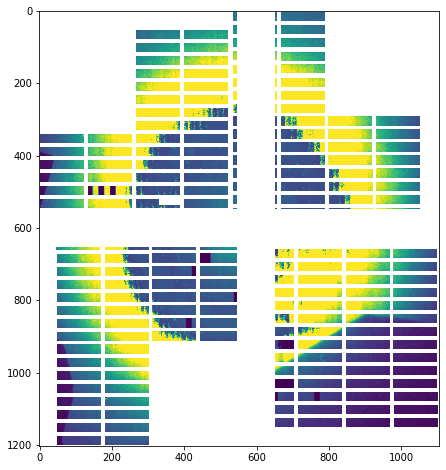

In [13]:
_, ax = plt.subplots(figsize=(8, 8))

ax.imshow(assembled[0], vmin=0, vmax=1500)

### Save image mask in modules to use it later

It is convenient to only draw an image mask once and reuse it again even when the geometry has changed. The follow code will demonstrate how to dismantle image mask into modules. Then one can save and use it the next time by assembling the mask in modules using the latest geometry.

In [14]:
mask_in_modules = geom.output_array_for_dismantle_fast(dtype=np.bool)
mask_in_modules.shape

(16, 256, 256)

In [15]:
geom.dismantle_all_modules(image_mask, out=mask_in_modules)

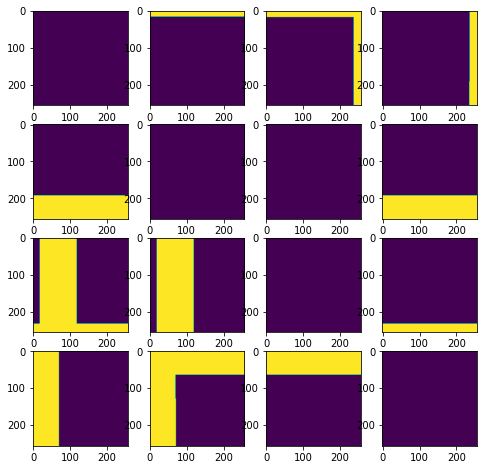

In [16]:
_, ax = plt.subplots(4, 4, figsize=(8, 8))

for i, axis in enumerate(ax.flatten()):
    axis.imshow(mask_in_modules[i], vmin=0, vmax=1)

One can save the mask in modules which is a 3D `numpy.array`.

Next time, one can load the saved mask and assemble it using a geometry.

In [17]:
image_mask_new = geom.output_array_for_position_fast(dtype=np.bool)
geom.position_all_modules(mask_in_modules, out=image_mask_new)

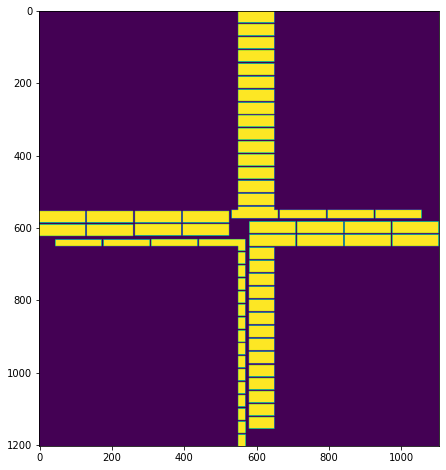

In [18]:
_, ax = plt.subplots(figsize=(8, 8))

ax.imshow(image_mask_new, vmin=0, vmax=1)